In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from sklearn import preprocessing
from sklearn.metrics import r2_score , mean_absolute_error , mean_absolute_percentage_error , mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle
import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
os.chdir('C:\\Users\\santa\\OneDrive\\Documents\\KMUTT-4\\Final_PJ\\Data')
data = pd.read_csv('Merged Data.csv')
data.head()

,Date,Value,Policy rate
0,2005-02-28,38.459500,2.00
1,2005-03-31,38.556522,2.25
2,2005-04-30,39.515952,2.25
3,2005-05-31,39.762045,2.25
4,2005-06-30,40.886818,2.50


In [4]:
X = pd.to_datetime(data['Date']).astype('int64').values.reshape(-1, 1)
policy_rate = data['Policy rate'].values.reshape(-1, 1)
X = np.concatenate((X, policy_rate), axis=1)  # เพิ่ม Policy rate เข้าไปใน feature
y = data['Value']

In [5]:
# แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# ทำการสเกลข้อมูล
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# ฝึกโมเดล SVR
svr_model = SVR(kernel='rbf', C=100, gamma='auto')  # ตั้งค่าพารามิเตอร์ของ SVR
svr_model.fit(X_train_scaled, y_train)

SVR(C=100, gamma='auto')

In [8]:
predictions = []

for i in range(3):
    # นับเวลา i เดือนหลังจากเดือนปัจจุบัน
    next_month = pd.to_datetime('2024-06-01') + pd.DateOffset(months=i)
    next_month = np.array([[next_month.timestamp()]])  # แปลงให้มีรูปแบบเหมือนกับ next_month_policy_rate

    # หาค่าเฉลี่ยของอัตราการเปลี่ยนแปลงของอัตราดอกเบี้ย
    your_policy_rate_value = data['Policy rate'].diff().mean()

    # ระบุค่า Policy rate ของเดือนถัดไป
    next_month_policy_rate = np.array([[your_policy_rate_value]])

    # ทำการสเกลข้อมูล
    next_month_combined = np.concatenate((next_month, next_month_policy_rate), axis=1)
    next_month_scaled = scaler.transform(next_month_combined)

    # ทำการทำนาย
    next_month_prediction = svr_model.predict(next_month_scaled)
    predictions.append(next_month_prediction)

print("Predictions for the next 3 months:", predictions)

Predictions for the next 3 months: [array([39.02444895]), array([39.02444895]), array([39.02444895])]


In [9]:
y_pred = svr_model.predict(X_test_scaled)

In [10]:
print('Evaluation Result for Test data : ','\n')
print('R2 Score for Test data: {0:.2f} %'.format(100*r2_score(y_test, y_pred)),'\n')
print('Mean Squared Error: ', mean_squared_error(y_test, y_pred),'\n')
print('Mean Absolute Error: ', mean_absolute_error(y_test, y_pred),'\n')
print('Root Mean Squared Error: ', sqrt(mean_squared_error(y_test, y_pred)),'\n')
print('Mean Absolute Percentage Error: {0:.2f} %'.format(100*mean_absolute_percentage_error(y_test, y_pred)),'\n')

Evaluation Result for Test data :  

R2 Score for Test data: 85.19 % 

Mean Squared Error:  0.9383592044501432 

Mean Absolute Error:  0.65347413433745 

Root Mean Squared Error:  0.9686894262095272 

Mean Absolute Percentage Error: 1.95 % 



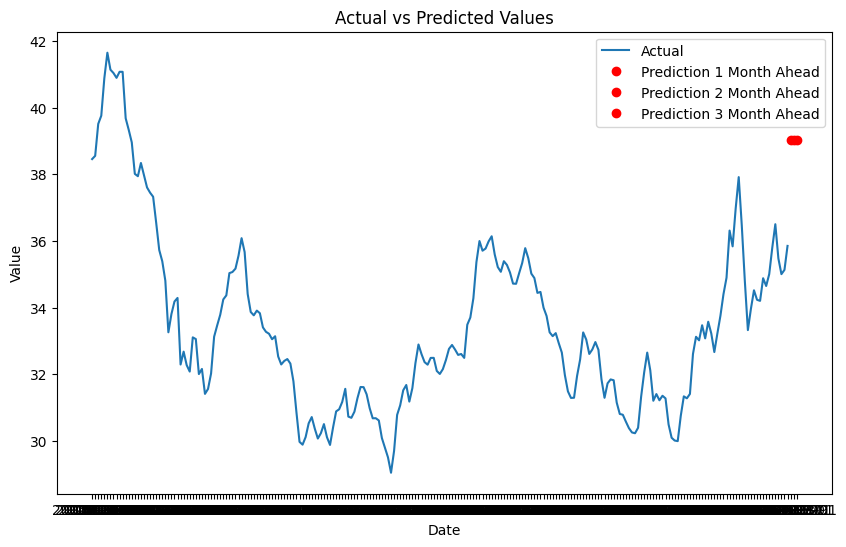

In [15]:
# พล็อตกราฟ
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Value'], label='Actual')  # พล็อตข้อมูลจริง
for i, prediction in enumerate(predictions):
    next_month_date = pd.to_datetime('2024-06-01') + pd.DateOffset(months=i)  # วันที่ของเดือนถัดไป
    next_month_date_str = next_month_date.strftime('%Y-%m-%d')  # แปลงเป็นรูปแบบที่ matplotlib เข้าใจได้
    plt.plot(next_month_date_str, prediction, 'ro', label=f'Prediction {i+1} Month Ahead')  # พล็อตข้อมูลการทำนาย
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.savefig('Foreign Exchange Rate Prediction SVR.png')
plt.show()


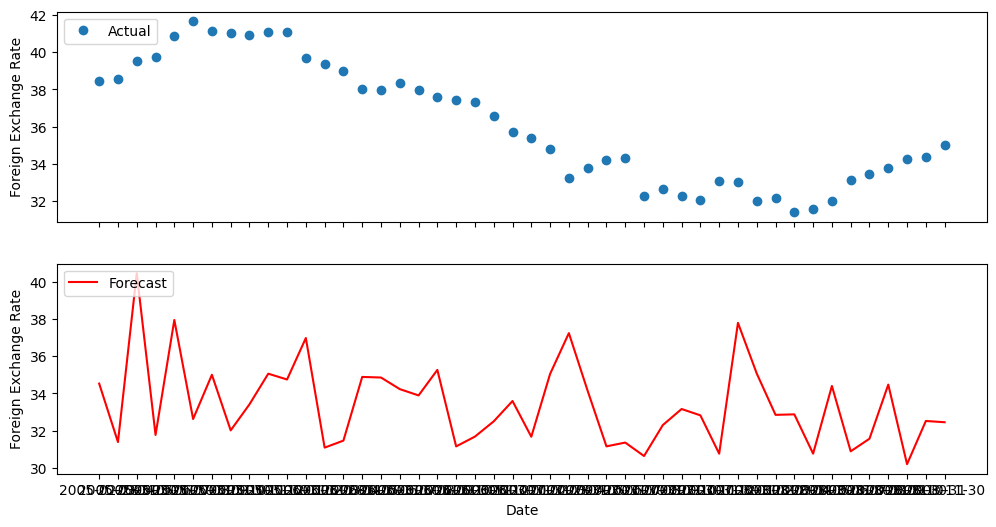

In [12]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(data['Date'][:len(y_pred)], y[:len(y_pred)], 'o', label='Actual')
ax[0].set_ylabel('Foreign Exchange Rate')
ax[1].plot(data['Date'][:len(y_pred)], y_pred, 'r', label='Forecast')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Foreign Exchange Rate')
for ax_ in ax:
    legend = ax_.legend(loc='upper left')
    legend.get_frame().set_facecolor('w')
plt.show()